# Verkefni 1

Davíð Helgason  (dah38@hi.is)

In [1]:
# Imports

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage # notum þetta fyrir myndir

# Notað til að mæla tímamismun.
import datetime

# Staðbundin skrá, notuð að framkvæma k-means klösun (e. k-means clustering)
import kmeans

# PIL.Image, nota þetta tímabundið fyrir myndir til að lækka upplausnina
# á myndinni, verður skipt út fyrir scipy.ndimage seinna
import PIL

# Stærðfræði
import math

# Notað til að finna skrár.
import glob

# Fyrir tölfræðilegar upplýsingar
import statistics

Hugtök
* centroid = þungamiðja, þyngdarpunktur, miðpunktur
* label = merki

Föll til að aflúsa

In [2]:
# Compares 3D NumPy arrays 'a' and 'b'.  I used
# this for debugging purposes.
def _arr_compare(a, b):
    for i in range(len(a)):
        for j in range(len(a[i])):
            for k in range(len(a[i][j])):
                c = (a[i][j][k] == b[i][j][k])
                if not c:
                    print("oh noes!")


Sameiginleg föll

In [3]:
# Sameiginleg föll

# Breytir löguninni NumPy myndafylkinu `arr' þannig
# lögunin á því sé samhæft kmeans fallinu.
def imgarr2kmeansf(arr):
    return (arr.reshape(-1, arr.shape[-1])).transpose()


# Býr til mynd út frá NumPy fylki
# EYÐA
def arr2img(arr):
    return Image.fromarray(arr.astype('uint8'))


# Les inn mynd með SciPy og skilar henni sem
# 3D NumPy fylki.
def load_image_as_arr(path):
    img = scipy.ndimage.imread(path)
    arr = np.asarray(img, dtype='uint8')
    return arr


# Birtir NumPY fylkið `arr' sem mynd.
def display_arr(arr):
    plt.imshow(arr, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0,vmax=255)
    plt.show()


# G.r.f. að lögunin á `arr' sé (N, w, h) þar sem `N' sé fjöldi mynda,
# `w' er breidding á hverri mynd og `h' sé hæðin á hverri mynd.
#
# Þannig hver og ein mynd er í laginu eins og (w, h).
def get_kmeans(arr, k=1, modified=True):
    
    # Breytir löguninni á `arr' frá (N, w, h) yfir í (w * h, N)
    # þannig fylkið er tilbúið fyrir k-means
    data = arr.reshape(arr.shape[0], -1).transpose()
    
    # Framkvæmir k-means á `data' og skilar c=þyngdarpunktum (e. centroids),
    # l=merkjum (e. labels) og J=tapi (e. losses) eða skekkju.
    # Hver þyngdarpunktur virkar sem fulltrúi fyrir þann klasa (e. cluster).
    # Fjöldi ítranna er lengdin á J.
    # Merkin segja hvaða fulltrúa mynd tilheyrir.
    # `c' er í laginu eins og (w * h, k)
    c, l, J = kmeans.kmeans(data, k)
    
    # Hvort við viljum skila úr kmeans breytt.
    if modified:
        # Breytum skilagildinu úr k-means þannig `c'
        # er í laginu eins og (k, w, h).
        
        # Breyta fylkjunum þannig
        # þau eru í laginu eins og mynd og hægt
        # að teikna þau
        # Byltu fylkinu þannig það er í laginu eins og (k, w * h)
        c2 = c.transpose()
    
        # Breytum lögunni á fylkinu þannig það sé í laginu eins og (k, w, h)
        c2 = c2.reshape(c2.shape[0], *arr.shape[1:])
        
        # Skilum úr k-means aðlagað.
        return (c2, l, J)
    else:
        # Skilum úr k-means óbreytt.
        return (c, l, J)

Búa til gögn hér.

In [ ]:
# Búum hér sífellt til bundle og vistum út í skrá
while False:
    # Hluti 1
    # Hluti 2
    bundles = create_bundles(the_images, [10, 20, 30])
    for bundle in bundles:
        save_bundle(bundle)

## Fyrri hluti

Lalala

In [4]:
# Sækjum albúm myndirnar, breytum þeim í NumPy fylki
# og geymum þær í listanum hér.
p1images = []
for path in glob.glob('albums/*.jpg'):
    p1images += [load_image_as_arr(path)]


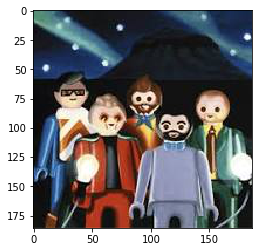

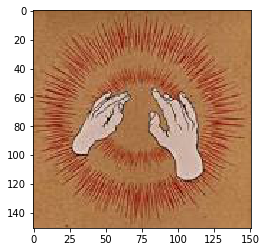

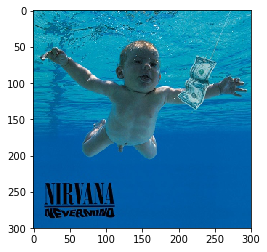

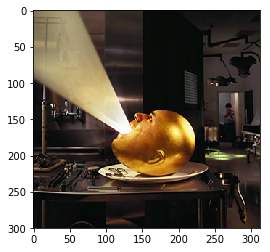

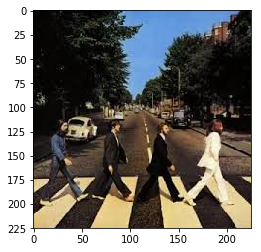

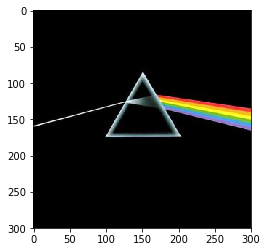

In [5]:
# Birtum allar myndirnar í p1images
for img in p1images:
    display_arr(img)


In [6]:
def gzf(arr, k):
    # Gera myndina fylkið (tilbúið fyrir )
    data = imgarr2kmeansf(arr)
    
    # Nota k-means á fylkið
    centroids, labels, losses = kmeans.kmeans(data, 5)
    
    # Sýna myndina
    plt.imshow(arr, interpolation='nearest')
    plt.show()
    
    # Sýna litina
    centroids_transposed = centroids.transpose()
    centroids_transposed = np.reshape(centroids_transposed, (1,) + centroids_transposed.shape)
    centroids_image = arr2img(centroids_transposed)

    plt.imshow(centroids_image, interpolation='nearest')
    plt.show()

    # Sýna fjölda ítranna
    print("ítranir", len(losses))
    print("Best", losses[-1])

    # Teikna fjölda ítrana
    plt.plot(range(0, len(losses)), losses)
    plt.show()



In [7]:
#gzf(p1images[0], 5)

## Seinni hluti

Verkferli

* (valfrjálst) skiptum inntakinu í 2 hluti, 90% til þjálfunar og 10% til að prófa
* Gera myndirnar (fylkið) tilbúnnar fyrir k-means
    * Fáum shape = (N, 28, 28) þar sem N er fjöldi mynda, viljum fá shape = (784, N)
    * Hver mynd verður að 784-vigri (28 x 28 = 784)
    * Notum:
        * reshape
        * transpose
        * etc..
* Þegar myndirnar eru orðnar tilbúnnar keyrum við k-means fyrir
    * k = 10, k = 20 og k = 30
* Fáum centroid fylki sem er shape (784, k)
* Breytum fulltrúunum (centroids) aftur í myndir, fáum k myndir, eina fyrir hvern fulltrúa.
* Þurfum að finna út hvaða merki (e. labels) hver þungamiðjupunktur (e. centroid) er fulltrúi fyrir.
    * Skoða hvaða myndir tilheyra þyrpingunni.
    * Mæla fjarlægðir milli hvers vigurs og þungamiðjupunkts og þannig gefa því merki samkvæmt því.
* Nota fulltrúanna til að greina myndirnar í test menginu og mæla villu í prósentum.
* Randome-a röðun á myndum?

Hérna lesum við inn myndirnar

In [8]:
# Lesa inn 10 þús. myndir ásamt meðfylgjandi merkingum
# notað í þjálfun.
A_images = np.load('mnist/A_images.npy')
A_labels = np.load('mnist/A_labels.npy')


# Les inn 1 þús. myndir ásamt meðfylgjandi merkingum,
# notað til að prófa á móti.
B_images = np.load('mnist/B_images.npy')
B_labels = np.load('mnist/B_labels.npy')


In [9]:
# Placeholder functions
def f1(arr, k=1, modified=True):
    get_kmeans(arr, k, modified)





In [10]:
def f2(images, image_labels, centroids, labels, losses):
    stat = []
    for _ in centroids:
        sub = []
        for i in range(len(centroids)):
            sub += [[i, 0]]
        stat += [sub]
    #print(stat)
    
    for i, label in enumerate(labels):
        value = int(image_labels[i])
        stat[label][value][1] += 1
        #print(label, value)
        
    for i, it in enumerate(stat):
        n = sum([x[1] for x in it])
        #print(n)
        stat[i] = sorted(it, key=lambda x: -x[1])
        for j in range(len(stat[i])):
            stat[i][j][1] /= n
        #print(stat[i])
    
    for i, it in enumerate(centroids):
        display_arr(centroids[i])
        print("Centroid", i + 1, "/", len(centroids), "is")
        for j, it2 in enumerate(stat[i]):
            print("  ", it2[0], " with a prob. of", int(100 * it2[1]), "%")
            if j > 1:
                break
        print()

In [11]:
def create_bundle(images, k, include_source=False):
    duration = datetime.datetime.now()
    centroids, labels, losses = f1(images, k)
    duration = datetime.datetime.now() - duration
    result = (str(duration), k, centroids, labels, losses)
    if include_source:
        result += (images,)
    return result
    

def create_bundles(images, k_list):
    bundles = []
    for k in k_list:
        bundle = create_bundle(images, k)
        bundles += [bundle]
    return bundles


def save_bundle(bundle):
    the_date = datetime.datetime.now()
    the_date_string = the_date.strftime("%y-%m-%d-%H%M%S.%f")
    filename = "bundle-" + the_date_string + ".npy"
    payload = np.array({
        "filename": filename,
        "dateString": the_date_string,
        "bundle": bundle
    })
    np.save(filename, payload)

    
def load_bundle(path):
    return np.load(path)


def get_list_of_bundles(path):
    pass

In [12]:
the_images = A_images
the_labels = A_labels

Í hvert skipti sem k-means er keyrt fyrir þjálfunarsafnið þá er niðurstaðan vistað út í skrá.  Skrárnar hér eru fyrir neðan.

In [30]:
def get_best_bundle(glob_pattern, chosen_k):
    paths = glob.glob(glob_pattern)
    least_loss = -1
    least_bundle = None
    least_path = ""
    uninitialized = True
    
    for path in paths:
        bundle = np.load(path).item()['bundle']
        duration, k, centroids, labels, losses = bundle
        if k == chosen_k:
            loss = losses[-1]
            if uninitialized:
                least_loss = loss
                uninitialized = False
            if loss < least_loss:
                least_loss = loss
                least_bundle = bundle
                least_path = path
    print("k", chosen_k, "path", least_path)
    
    return least_bundle

In [31]:
glob_pattern_2 = 'bundles-2/bundle-*.npy'

bundle10 = get_best_bundle(glob_pattern_2, 10)
bundle20 = get_best_bundle(glob_pattern_2, 20)
bundle30 = get_best_bundle(glob_pattern_2, 30)

k 10 path bundles-2/bundle-17-03-06-102636.236139.npy
k 20 path bundles-2/bundle-17-03-06-081925.801532.npy
k 30 path bundles-2/bundle-17-03-06-092330.771659.npy


In [17]:
# Takes about 50 - 60 sec. with 10 thousand images
def test(bundle, images, image_labels):
    duration, k, centroids, labels, losses = bundle
    plt.plot(range(0, len(losses)), losses)
    f2(images, image_labels, centroids, labels, losses)
    print("--- --- --- ---")


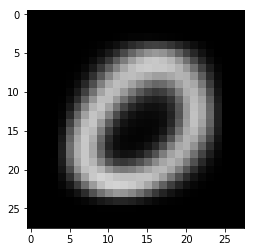

Centroid 1 / 10 is
   0  with a prob. of 94 %
   6  with a prob. of 1 %
   5  with a prob. of 1 %



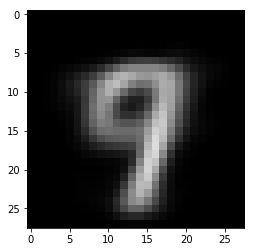

Centroid 2 / 10 is
   7  with a prob. of 36 %
   9  with a prob. of 32 %
   4  with a prob. of 22 %



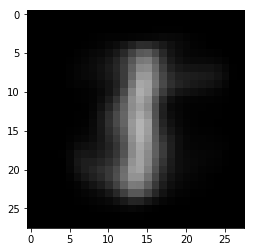

Centroid 3 / 10 is
   1  with a prob. of 40 %
   5  with a prob. of 18 %
   2  with a prob. of 9 %



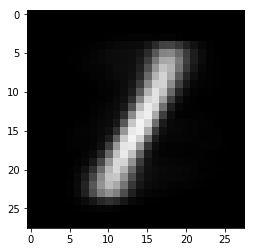

Centroid 4 / 10 is
   1  with a prob. of 78 %
   2  with a prob. of 7 %
   7  with a prob. of 4 %



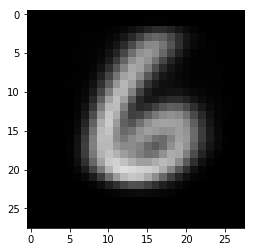

Centroid 5 / 10 is
   6  with a prob. of 85 %
   0  with a prob. of 4 %
   2  with a prob. of 2 %



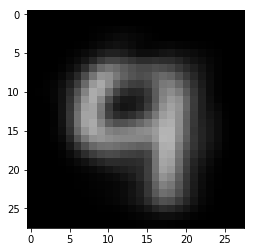

Centroid 6 / 10 is
   4  with a prob. of 40 %
   9  with a prob. of 26 %
   7  with a prob. of 11 %



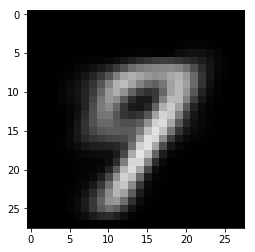

Centroid 7 / 10 is
   7  with a prob. of 41 %
   9  with a prob. of 26 %
   4  with a prob. of 24 %



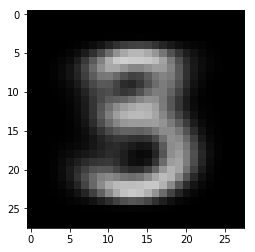

Centroid 8 / 10 is
   3  with a prob. of 50 %
   5  with a prob. of 20 %
   8  with a prob. of 17 %



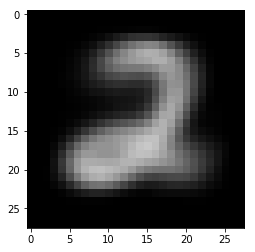

Centroid 9 / 10 is
   2  with a prob. of 91 %
   3  with a prob. of 4 %
   6  with a prob. of 1 %



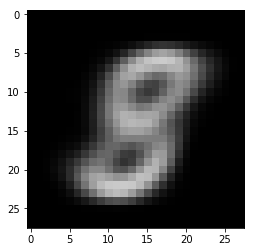

Centroid 10 / 10 is
   8  with a prob. of 44 %
   3  with a prob. of 21 %
   5  with a prob. of 20 %

--- --- --- ---


In [18]:


#print(the_bundle)
test(bundle10, the_images, the_labels)

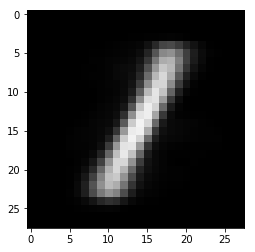

Centroid 1 / 20 is
   1  with a prob. of 84 %
   2  with a prob. of 4 %
   7  with a prob. of 4 %



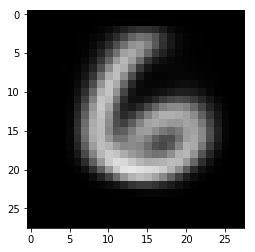

Centroid 2 / 20 is
   6  with a prob. of 93 %
   4  with a prob. of 1 %
   5  with a prob. of 1 %



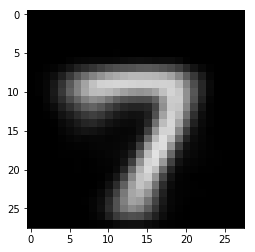

Centroid 3 / 20 is
   7  with a prob. of 92 %
   9  with a prob. of 4 %
   2  with a prob. of 1 %



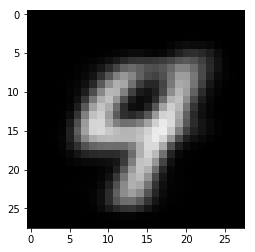

Centroid 4 / 20 is
   4  with a prob. of 66 %
   9  with a prob. of 26 %
   7  with a prob. of 2 %



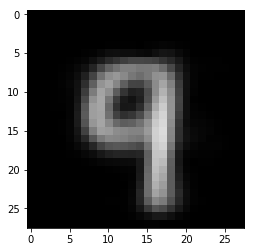

Centroid 5 / 20 is
   9  with a prob. of 44 %
   4  with a prob. of 38 %
   7  with a prob. of 10 %



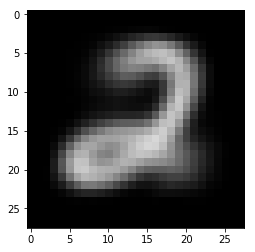

Centroid 6 / 20 is
   2  with a prob. of 94 %
   3  with a prob. of 2 %
   8  with a prob. of 1 %



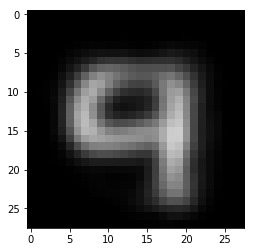

Centroid 7 / 20 is
   4  with a prob. of 45 %
   9  with a prob. of 30 %
   7  with a prob. of 11 %



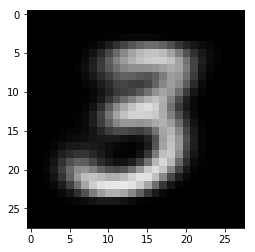

Centroid 8 / 20 is
   3  with a prob. of 77 %
   5  with a prob. of 15 %
   8  with a prob. of 3 %



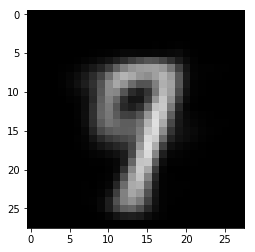

Centroid 9 / 20 is
   9  with a prob. of 37 %
   7  with a prob. of 36 %
   4  with a prob. of 17 %



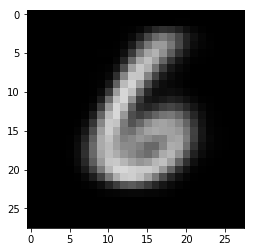

Centroid 10 / 20 is
   6  with a prob. of 90 %
   0  with a prob. of 3 %
   5  with a prob. of 1 %



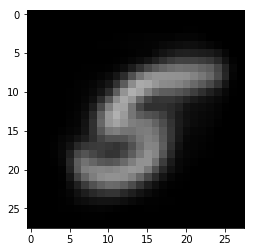

Centroid 11 / 20 is
   5  with a prob. of 63 %
   8  with a prob. of 7 %
   4  with a prob. of 7 %



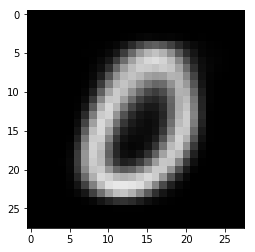

Centroid 12 / 20 is
   0  with a prob. of 88 %
   5  with a prob. of 5 %
   6  with a prob. of 2 %



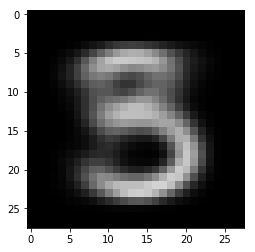

Centroid 13 / 20 is
   3  with a prob. of 49 %
   5  with a prob. of 29 %
   8  with a prob. of 16 %



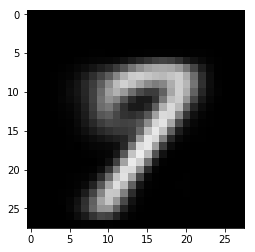

Centroid 14 / 20 is
   7  with a prob. of 60 %
   9  with a prob. of 31 %
   4  with a prob. of 4 %



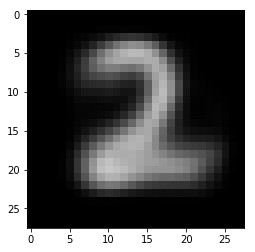

Centroid 15 / 20 is
   2  with a prob. of 93 %
   6  with a prob. of 1 %
   3  with a prob. of 1 %



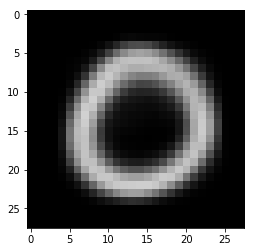

Centroid 16 / 20 is
   0  with a prob. of 95 %
   5  with a prob. of 1 %
   8  with a prob. of 1 %



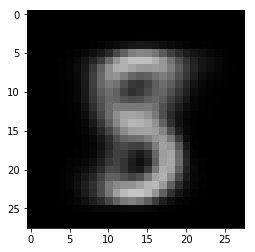

Centroid 17 / 20 is
   8  with a prob. of 35 %
   3  with a prob. of 31 %
   5  with a prob. of 25 %



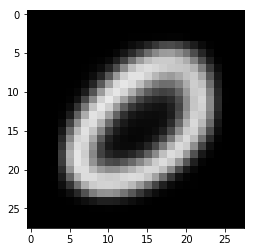

Centroid 18 / 20 is
   0  with a prob. of 95 %
   6  with a prob. of 2 %
   2  with a prob. of 1 %



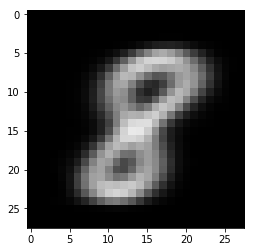

Centroid 19 / 20 is
   8  with a prob. of 86 %
   3  with a prob. of 7 %
   5  with a prob. of 2 %



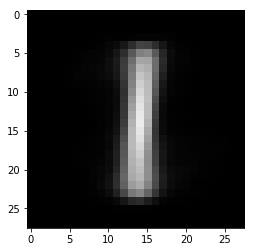

Centroid 20 / 20 is
   1  with a prob. of 79 %
   2  with a prob. of 5 %
   3  with a prob. of 4 %

--- --- --- ---


In [20]:
test(bundle20, the_images, the_labels)

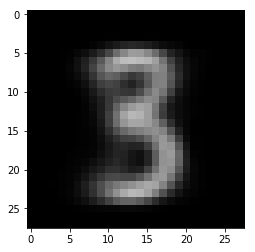

Centroid 1 / 30 is
   3  with a prob. of 55 %
   8  with a prob. of 23 %
   5  with a prob. of 11 %



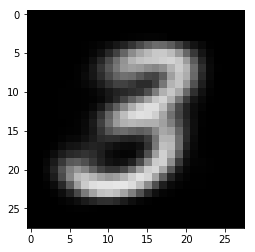

Centroid 2 / 30 is
   3  with a prob. of 82 %
   8  with a prob. of 8 %
   5  with a prob. of 4 %



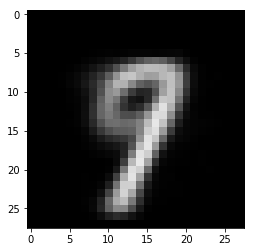

Centroid 3 / 30 is
   9  with a prob. of 47 %
   7  with a prob. of 37 %
   4  with a prob. of 7 %



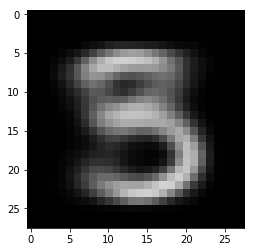

Centroid 4 / 30 is
   3  with a prob. of 49 %
   5  with a prob. of 28 %
   8  with a prob. of 18 %



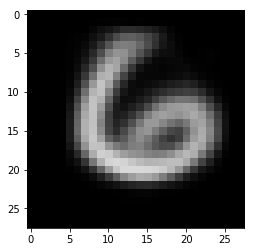

Centroid 5 / 30 is
   6  with a prob. of 90 %
   0  with a prob. of 5 %
   4  with a prob. of 2 %



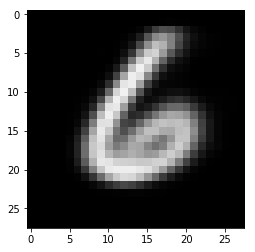

Centroid 6 / 30 is
   6  with a prob. of 95 %
   2  with a prob. of 1 %
   0  with a prob. of 0 %



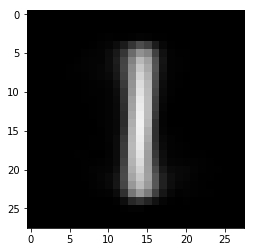

Centroid 7 / 30 is
   1  with a prob. of 88 %
   2  with a prob. of 3 %
   8  with a prob. of 1 %



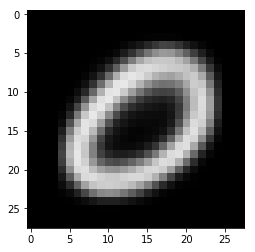

Centroid 8 / 30 is
   0  with a prob. of 96 %
   6  with a prob. of 1 %
   2  with a prob. of 1 %



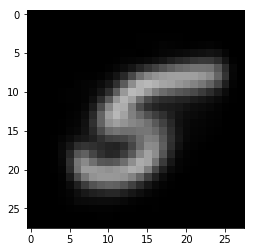

Centroid 9 / 30 is
   5  with a prob. of 80 %
   8  with a prob. of 6 %
   0  with a prob. of 3 %



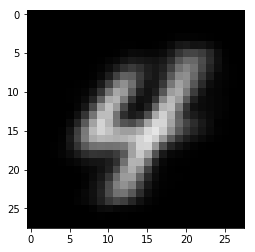

Centroid 10 / 30 is
   4  with a prob. of 86 %
   8  with a prob. of 5 %
   9  with a prob. of 5 %



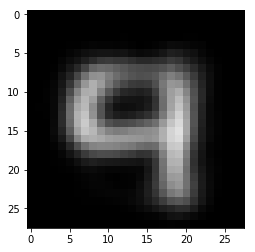

Centroid 11 / 30 is
   4  with a prob. of 52 %
   9  with a prob. of 30 %
   7  with a prob. of 11 %



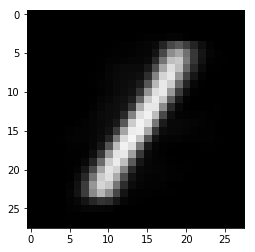

Centroid 12 / 30 is
   1  with a prob. of 83 %
   7  with a prob. of 5 %
   4  with a prob. of 3 %



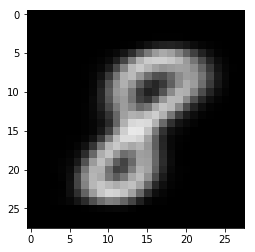

Centroid 13 / 30 is
   8  with a prob. of 91 %
   2  with a prob. of 3 %
   3  with a prob. of 3 %



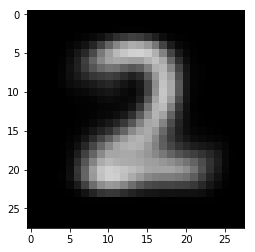

Centroid 14 / 30 is
   2  with a prob. of 95 %
   3  with a prob. of 2 %
   1  with a prob. of 1 %



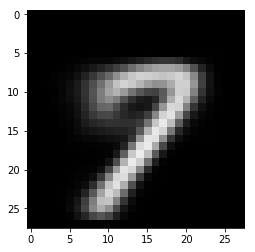

Centroid 15 / 30 is
   7  with a prob. of 72 %
   9  with a prob. of 22 %
   4  with a prob. of 1 %



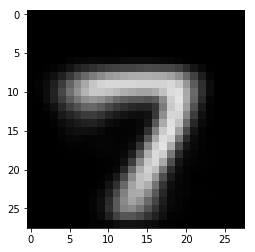

Centroid 16 / 30 is
   7  with a prob. of 95 %
   9  with a prob. of 2 %
   2  with a prob. of 1 %



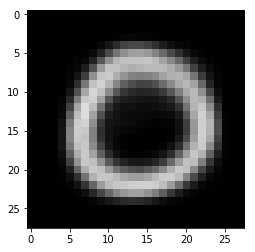

Centroid 17 / 30 is
   0  with a prob. of 95 %
   8  with a prob. of 2 %
   5  with a prob. of 1 %



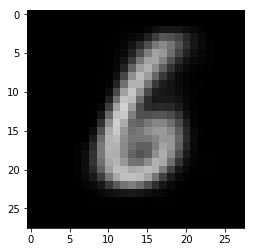

Centroid 18 / 30 is
   6  with a prob. of 77 %
   0  with a prob. of 6 %
   5  with a prob. of 4 %



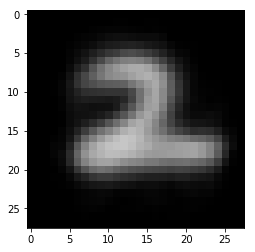

Centroid 19 / 30 is
   2  with a prob. of 85 %
   7  with a prob. of 5 %
   3  with a prob. of 3 %



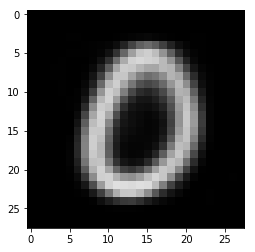

Centroid 20 / 30 is
   0  with a prob. of 92 %
   2  with a prob. of 2 %
   5  with a prob. of 2 %



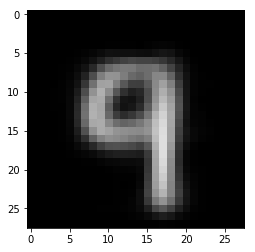

Centroid 21 / 30 is
   9  with a prob. of 44 %
   4  with a prob. of 41 %
   7  with a prob. of 9 %



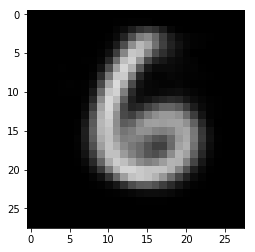

Centroid 22 / 30 is
   6  with a prob. of 87 %
   5  with a prob. of 4 %
   8  with a prob. of 2 %



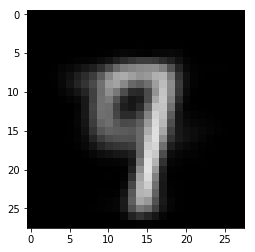

Centroid 23 / 30 is
   7  with a prob. of 40 %
   9  with a prob. of 33 %
   4  with a prob. of 22 %



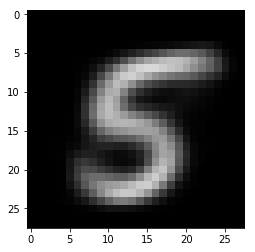

Centroid 24 / 30 is
   5  with a prob. of 86 %
   8  with a prob. of 7 %
   3  with a prob. of 3 %



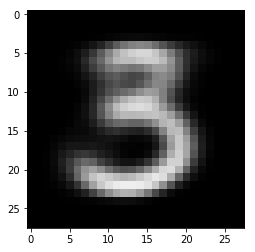

Centroid 25 / 30 is
   3  with a prob. of 64 %
   5  with a prob. of 28 %
   8  with a prob. of 4 %



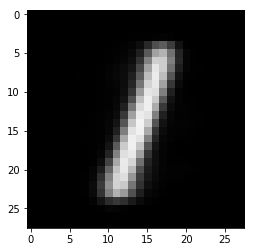

Centroid 26 / 30 is
   1  with a prob. of 87 %
   2  with a prob. of 3 %
   7  with a prob. of 3 %



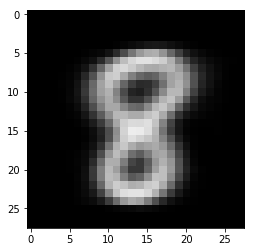

Centroid 27 / 30 is
   8  with a prob. of 90 %
   3  with a prob. of 6 %
   2  with a prob. of 1 %



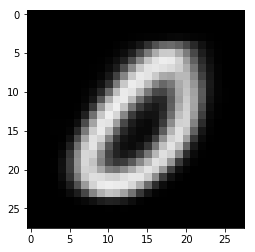

Centroid 28 / 30 is
   0  with a prob. of 91 %
   6  with a prob. of 2 %
   2  with a prob. of 1 %



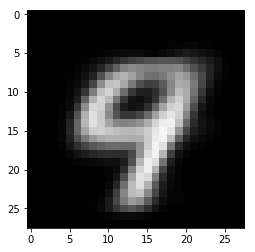

Centroid 29 / 30 is
   4  with a prob. of 47 %
   9  with a prob. of 44 %
   7  with a prob. of 5 %



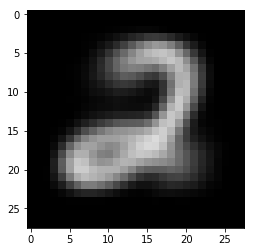

Centroid 30 / 30 is
   2  with a prob. of 95 %
   3  with a prob. of 2 %
   8  with a prob. of 0 %

--- --- --- ---


In [19]:
test(bundle30, the_images, the_labels)

In [ ]:
# Plot number of iterations and total loss (error) at each point
#plt.plot(range(0, len(losses)), losses)


In [ ]:
#test(bundles[0], the_images, the_labels)

In [ ]:
#test(the_images, the_labels, 20)

In [ ]:
#test(the_images, the_labels, 30)